# 2024 CITS4012 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Install packages and load libraries

In [1]:
!pip install skorch
import pandas as pd
import json
import numpy as np
import re
import nltk
import torch
import gensim.downloader as api
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

## Image saving configuration

In [2]:
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(
    fig_id,
    tight_layout=False,
    fig_extension="png",
    resolution=300,
    bbox_inches="tight",
    pad_inches=0.3,
    **kwargs,
):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(
        path,
        format=fig_extension,
        dpi=resolution,
        bbox_inches=bbox_inches,
        pad_inches=pad_inches,
        **kwargs,
    )

## Download and load data

In [3]:
# !pip install -U -q PyDrive2
# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Code to download file into Colaboratory:
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# downloaded1 = drive.CreateFile({'id': '1nCCtN3vE6ujkZ4fRxqfO7WfONF0Le7jz'})
# downloaded1.GetContentFile('test.json')
# downloaded2 = drive.CreateFile({'id': '1TIK7kyjmUn93ppgYjLL9YgMbFF99duhl'})
# downloaded2.GetContentFile('train.json')
# downloaded3 = drive.CreateFile({'id': '1PUCSzVYiwzsHWWaiDKm4tbdlTofIcL7n'})
# downloaded3.GetContentFile('val.json')

In [4]:
train_data = json.load(open("train.json"))
test_data = json.load(open("test.json"))
val_data = json.load(open("val.json"))

In [5]:
def create_dataframe(data):
    # Extract data points and column names
    records = data["data"]
    columns = data["columns"]

    # Create DataFrame
    df = pd.DataFrame(records, columns=columns)
    return df


# Convert to Pandas data frame
train_df = create_dataframe(train_data)
test_df = create_dataframe(test_data)
val_df = create_dataframe(val_data)

In [6]:
nltk.download("punkt")  # Download punkt tokenizer from nltk
nltk.download("stopwords")  # Download stopwords from nltk

# Assume the contraction_dict contains all the contractions
contraction_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}


stop_words = set(stopwords.words("english"))  # Load the list of stop words


def preprocess_text(sentence):
    # Convert into lowercase
    sentence = sentence.lower()
    # Convert contractions into uncontracted forms
    for word, expanded in contraction_dict.items():
        sentence = sentence.replace(word, expanded)
    # Remove punctuations
    sentence = re.sub(r"[^\w\s]", "", sentence)
    # Tokenize the sentence
    tokens = word_tokenize(sentence)
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)  # Return the processed sentence


def create_preprocessed_df(data):
    # Convert into DataFrame
    df = pd.DataFrame(data["data"], columns=data["columns"])
    # Preprocess each sentence
    df["processed_sentence"] = df["sentence"].apply(preprocess_text)
    return df


# Create and preprocess data frame
train_df = create_preprocessed_df(train_data)
test_df = create_preprocessed_df(test_data)
val_df = create_preprocessed_df(val_data)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chaoz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaoz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def calculate_max_length(df):
    # Calculate the length of each tokenised sentence
    df["sentence_length"] = df["processed_sentence"].apply(
        lambda x: len(word_tokenize(x))
    )
    # Get the maximum length
    max_length = df["sentence_length"].max()
    return max_length


# Calculate the maximum length of each dataset
max_length_train = calculate_max_length(train_df)
max_length_test = calculate_max_length(test_df)
max_length_val = calculate_max_length(val_df)

# Get the maximum length among those three datasets
max_length = max([max_length_train, max_length_test, max_length_val])
max_length

40

In [8]:
def pad_sentences(sentences, max_length, pad_token="[PAD]"):
    padded_sentences = []
    for sentence in sentences:
        # Split sentences into words by spaces
        words = sentence.split()
        if len(words) > max_length:
            # Truncate to maximum length
            padded_sentence = words[:max_length]
        else:
            # Padding to maximum length
            padded_sentence = words + [pad_token] * (max_length - len(words))
        padded_sentences.append(" ".join(padded_sentence))
    return padded_sentences


# Apply padding to each dataset
train_df["padded_sentence"] = pad_sentences(train_df["processed_sentence"], max_length)
test_df["padded_sentence"] = pad_sentences(test_df["processed_sentence"], max_length)
val_df["padded_sentence"] = pad_sentences(val_df["processed_sentence"], max_length)

In [9]:
# # Download and load the pretrained Word2Vec model
# word2vec_vectors = api.load("word2vec-google-news-300")

In [10]:
# word2vec_Model.save("word2vec_vectors.bin")

In [11]:
# If run locally
from gensim.models import KeyedVectors

word2vec_vectors = KeyedVectors.load("word2vec_vectors.bin")

In [12]:
def sentence_to_avg_vector(sentence, model):
    # Initialize a list of zero vectors to store vectors
    vectors = []
    for word in sentence:
        if word in model:
            vectors.append(model[word])
        else:
            # Use all-zero vectors to replace words that do not exist in the model
            vectors.append(np.zeros(model.vector_size))

    # Calculate the average of a vector
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


def process_data_frame(df, model):
    # Tokenize sentence
    df["tokenized_sentence"] = df["processed_sentence"].apply(str.split)

    # Convert each sentence to its vector representation
    df["sentence_vector"] = df["tokenized_sentence"].apply(
        lambda x: sentence_to_avg_vector(x, model)
    )

    return df


# Apply the function to each sentence
train_df = process_data_frame(train_df, word2vec_vectors)
test_df = process_data_frame(test_df, word2vec_vectors)
val_df = process_data_frame(val_df, word2vec_vectors)

## Model 1 data processing


Use Word2vec to produce word embeddings and concatenate the aspect representation and the sentence representation.

In [13]:
def aspect_to_vector(aspect, model):
    if aspect in model:
        return model[aspect]
    else:
        return np.zeros(model.vector_size)


def process_data(df, model):
    # For each aspect word in the DataFrame, obtain its vector representation
    df["aspect_vector"] = df["aspect"].apply(
        lambda x: aspect_to_vector(x, model))

    # Concatenate aspect representation and sentence representation (placing the aspect vector at the front)
    df["combined_vector_ahead"] = df.apply(
        lambda row: np.concatenate(
            (row["aspect_vector"], row["sentence_vector"])),
        axis=1,
    )

    return df


train_df1 = process_data(train_df, word2vec_vectors)
test_df1 = process_data(test_df, word2vec_vectors)
val_df1 = process_data(val_df, word2vec_vectors)

In [14]:
# Training data and labels
X_train_model1 = np.array(list(train_df1["combined_vector_ahead"]))
y_train_model1 = train_df1["polarity"]

# Validation data and labels
X_val_model1 = np.array(list(val_df1["combined_vector_ahead"]))
y_val_model1 = val_df1["polarity"]

# Test data and labels
X_test_model1 = np.array(list(test_df1["combined_vector_ahead"]))
y_test_model1 = test_df1["polarity"]

In [15]:
# Convert polarity information into indices (using one-hot encoding)
label_mapping = {"neutral": 0, "positive": 1, "negative": 2}
train_df1["polarity"] = train_df1["polarity"].map(
    label_mapping).fillna(-1).astype(int)
val_df1["polarity"] = val_df1["polarity"].map(
    label_mapping).fillna(-1).astype(int)
test_df1["polarity"] = test_df1["polarity"].map(
    label_mapping).fillna(-1).astype(int)

In [16]:
# Get the one-hot representation of the target variable
y_train_encoded1 = train_df1["polarity"]
y_val_encoded1 = val_df1["polarity"]
y_test_encoded1 = test_df1["polarity"]

# Convert to PyTorch tensor
y_train_t = torch.tensor(y_train_encoded1, dtype=torch.long)
y_val_t = torch.tensor(y_val_encoded1, dtype=torch.long)
y_test_t = torch.tensor(y_test_encoded1, dtype=torch.long)

# Convert to PyTorch tensor
X_train_t = torch.tensor(X_train_model1, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_val_model1, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_model1, dtype=torch.float32).unsqueeze(1)

# Create data loader
train_loader1 = DataLoader(
    TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True
)
val_loader1 = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader1 = DataLoader(
    TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False
)

## Model 2 and Model 3 data processing


model2 and model3 we need to use 'padded_sentence', 'aspect' and 'polarity' separately

In [17]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, word2vec_vectors, embedding_dim):
        # Convert sentences into embedding matrices
        self.sentences = [
            self.text_to_vec_list(text, word2vec_vectors, embedding_dim)
            for text in dataframe["padded_sentence"]
        ]
        # Convert apsect words to embedding vectors
        self.aspects = [
            self.word_to_vec(aspect, word2vec_vectors, embedding_dim)
            for aspect in dataframe["aspect"]
        ]
        # Make sure the label is a long integer tensor
        self.labels = torch.tensor(dataframe["polarity"].values, dtype=torch.long)

    def text_to_vec_list(self, text, word2vec_vectors, embedding_dim):
        # Convert each word into a pretrained embedding vector
        def word_to_vec(word):
            if word in word2vec_vectors:
                return torch.tensor(word2vec_vectors[word], dtype=torch.float)
            else:
                # For words not found, return a zero vector
                return torch.zeros(embedding_dim)

        # Split sentences and construct embedding matrix
        tokens = text.split()
        return torch.stack([word_to_vec(token) for token in tokens])

    def word_to_vec(self, word, word2vec_vectors, embedding_dim):
        # Convert aspect words to embedding vectors
        if word in word2vec_vectors:
            return torch.tensor(word2vec_vectors[word], dtype=torch.float)
        else:
            return torch.zeros(embedding_dim)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Return sentence embedding matrix, level word embedding vector and label
        return self.sentences[idx], self.aspects[idx], self.labels[idx]

In [18]:
# Define pretrained embedding model and embedding dimensions
embedding_dim = word2vec_vectors.vector_size

# Create three data sets
train_dataset = SentimentDataset(train_df, word2vec_vectors, embedding_dim)
val_dataset = SentimentDataset(val_df, word2vec_vectors, embedding_dim)
test_dataset = SentimentDataset(test_df, word2vec_vectors, embedding_dim)

# Create data loaders for each dataset
train_loader2 = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader2 = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader2 = DataLoader(test_dataset, batch_size=32, shuffle=False)

## GloVe word representation


In [ ]:
def build_vocab(sentences):
    word_count = Counter(word for sentence in sentences for word in sentence.split())
    vocab = ["<PAD>"] + sorted(word_count)
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    return vocab, word_to_index


def text_to_indices(sentences, word_to_index, max_len):
    indices = []
    for sentence in sentences:
        sentence_indices = [
            word_to_index.get(word, word_to_index["<PAD>"]) for word in sentence.split()
        ]
        padded_indices = sentence_indices + [word_to_index["<PAD>"]] * (
            max_len - len(sentence_indices)
        )
        indices.append(padded_indices[:max_len])
    return indices


all_sentences = (
    train_df["processed_sentence"].tolist()
    + test_df["processed_sentence"].tolist()
    + val_df["processed_sentence"].tolist()
)

vocab, word_to_index = build_vocab(all_sentences)
max_length = 40

train_indices = text_to_indices(
    train_df["processed_sentence"], word_to_index, max_length
)
test_indices = text_to_indices(test_df["processed_sentence"], word_to_index, max_length)
val_indices = text_to_indices(val_df["processed_sentence"], word_to_index, max_length)

# Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df["polarity"].tolist())
y_test_encoded = label_encoder.transform(test_df["polarity"].tolist())
y_val_encoded = label_encoder.transform(val_df["polarity"].tolist())

# Create tensor
train_indices_tensor = torch.tensor(train_indices, dtype=torch.long)
test_indices_tensor = torch.tensor(test_indices, dtype=torch.long)
val_indices_tensor = torch.tensor(val_indices, dtype=torch.long)

train_labels_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
val_labels_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

train_dataset = TensorDataset(train_indices_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_indices_tensor, test_labels_tensor)
val_dataset = TensorDataset(val_indices_tensor, val_labels_tensor)

batch_size = 64
train_loader_glo = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader_glo = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader_glo = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Create data loader
word_emb_model = api.load("glove-twitter-100")
word_emb_model2 = api.load("glove-twitter-200")
emb_dim = word_emb_model.vector_size + word_emb_model2.vector_size
emb_table = np.zeros((len(vocab), emb_dim))
for i, word in enumerate(vocab):
    if word in word_emb_model and word in word_emb_model2:
        emb_table[i] = np.concatenate((word_emb_model[word], word_emb_model2[word]))
    elif word in word_emb_model:
        emb_table[i, : word_emb_model.vector_size] = word_emb_model[word]
    elif word in word_emb_model2:
        emb_table[i, word_emb_model.vector_size :] = word_emb_model2[word]

[==================================================] 100.0% 387.1/387.1MB downloaded
[==================================================] 100.0% 758.5/758.5MB downloaded


# 2.Model Implementation

## Model 1 - Baseline BiLSTM1
Aspect representation is concatenated and placed at the front of input layer.

### Word2vec embedding version

In [19]:
class Model1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(Model1, self).__init__()
        # Bi-directional LSTM layer definition:
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

        # Fully connected layer that projects from hidden state space to output space
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # Get the last time-step output from all sequences in the batch
        polarity_space = self.fc(self.dropout(lstm_out[:, -1, :]))
        return F.softmax(polarity_space, dim=-1)

### GloVe embedding version

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, emb_table):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(emb_table))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

## Model 2 - Baseline BiLSTM2
Aspect representation is concatenated in the hidden layer and placed at the end.

In [20]:
class Model2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(Model2, self).__init__()
        # Bi-directional LSTM layer definition:
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

        # Fully connected layer that projects from hidden state space to output space
        self.fc = nn.Linear(hidden_dim * 2 + input_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, sentence_embeddings, aspect_embeddings):
        # Generate initial sentence representation using LSTM
        lstm_out, _ = self.lstm(sentence_embeddings)
        lstm_out_mean = torch.mean(
            lstm_out, dim=1
        )  # Average pooling to obtain the representation of the entire sentence

        # Concatenating LSTM outputs and aspect embeddings
        combined_representation = torch.cat(
            (lstm_out_mean, aspect_embeddings), dim=1)

        # Fully connected layer for classification
        polarity_space = self.fc(self.dropout(combined_representation))
        return F.softmax(polarity_space, dim=-1)

## Model 3

In [21]:
class Model3(nn.Module):
    def __init__(
        self, input_dim, aspect_dim, hidden_dim, output_dim, num_layers=1, dropout=0.1
    ):
        super(Model3, self).__init__()
        self.hidden_dim = hidden_dim

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=input_dim + aspect_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=False,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)

        # Attention layer parameters
        self.w = nn.Linear(hidden_dim + aspect_dim, 1)

        # final projection layer
        self.Wp = nn.Linear(hidden_dim, hidden_dim)
        self.Wx = nn.Linear(hidden_dim, hidden_dim)

        # Classifier
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentences, aspects):
        # Extend level word embeddings to dimensions matching sentences
        aspects_expanded = aspects.unsqueeze(
            1).expand(-1, sentences.size(1), -1)

        # Concatenate level word embeddings with each word vector
        lstm_input = torch.cat((sentences, aspects_expanded), dim=2)

        # LSTM output
        lstm_out, _ = self.lstm(lstm_input)
        lstm_out = self.dropout(lstm_out)

        # attention mechanism
        M = torch.tanh(torch.cat((lstm_out, aspects_expanded), dim=2))
        attention_weights = F.softmax(self.w(M), dim=1)
        attention_weights = attention_weights.transpose(1, 2)

        # weighted representation
        r = torch.bmm(attention_weights, lstm_out).squeeze(1)

        # The final expression of the combination
        h_star = torch.tanh(self.Wp(r) + self.Wx(lstm_out[:, -1, :]))

        # Classification output
        output = self.classifier(h_star)
        return F.log_softmax(output, dim=-1), attention_weights
        # return F.softmax(output, dim=-1), attention_weights

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Model 1 - Baseline BiLSTM

### Word2vec version

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()


def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    avg_loss = total_loss/len(data_loader)
    return avg_loss, accuracy, macro_f1


def train_and_evaluate(model, criterion, optimizer, num_epochs=10, verbose=True):
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []

        for data, targets in train_loader1:
            # Move data to GPU or CPU
            data, targets = data.to(device), targets.to(device)

            # Clear gradient
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(data)

            # Calculate loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record predictions and labels
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

        # Training set accuracy and loss
        train_accuracy = accuracy_score(all_labels, all_predictions)
        avg_train_loss = total_loss / len(train_loader1)

        # Validation set evaluation
        val_loss, val_accuracy, val_f1 = evaluate(model, val_loader1)
        val_losses.extend([val_loss])
        val_accuracies.extend([val_accuracy])

        if verbose:
            print(
                f"Epoch [{(epoch+1)}/{num_epochs}] | "
                f"Train Loss: {avg_train_loss:.2f} | Train Accuracy: {
                    train_accuracy:.2f} | "
                f"Val Loss: {val_loss:.2f} | Val Accuracy: {val_accuracy:.2f}"
            )

    return val_losses, val_accuracies

### GloVe version

### Simple grid search

In [23]:
model = NeuralNetClassifier(
    Model1,
    module__input_dim=X_train_t.shape[2],
    module__hidden_dim=128,
    module__output_dim=3,
    module__num_layers=2,
    module__dropout=0.3,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=10,
    batch_size=64,
    optimizer=optim.Adagrad,
    optimizer__lr=0.01,
    verbose=True,
)

param_grid = {
    # "module__dropout": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  # 0.3
    # "optimizer": [  # optim.Adadelta, optim.SGD, optim.RMSprop,
    #     optim.Adam,
    #     optim.Adamax,
    #     optim.NAdam,
    #     optim.Adagrad,
    # ],  # optim.Adagrad
    "optimizer__lr": [0.0001, 0.001, 0.01, 0.1],  # 0.01
    # "batch_size": [16, 32, 64, 128, 256],  # 64
    # "max_epochs": [10, 30, 50, 70, 100],  # 10
    # "module__hidden_dim": [64, 128, 256, 512],  # 128
}

grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    n_jobs=-1, cv=10, verbose=5)
grid_result = grid.fit(X_val_t, y_val_t)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("Mean Validation Accuracy %.4f (%.4f) with: %r" %
          (mean, stdev, param))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9810       0.5730        0.9716  0.1795
      2        0.9373       0.5843        0.9643  0.1376
      3        0.9268       0.5787        0.9678  0.1506
      4        0.9119       0.5843        0.9586  0.1975
      5        0.9018       0.5674        0.9603  0.1835
      6        0.8957       0.5618        0.9606  0.1855
      7        0.8785       0.5618        0.9694  0.2154
      8        0.8722       0.5618        0.9640  0.1845
      9        0.8669       0.5393        0.9885  0.1755
     10        0.8625       0.5787        0.9519  0.1715
Best: 0.626124 using {'optimizer__lr': 0.01}
Mean Validation Accuracy 0.4065 (0.0896) with: {'optimizer__lr': 0.0001}
Mean Validation Accuracy 0.5845 (0.0346) with: {'optimizer__lr': 0.001}
Mean Validation Accuracy 0.6261 (0.0458) with: {'optimizer__lr': 

### Comparing word embeddings

### Tuning learning rate

--------------------------------------------------------------------------------------------------------------
Learning rate = 1e-05
End of training | Val Accuracy: 0.29 | Val Macro-F1: 0.15 | Val Loss: 1.10
--------------------------------------------------------------------------------------------------------------
Learning rate = 0.0001
End of training | Val Accuracy: 0.57 | Val Macro-F1: 0.43 | Val Loss: 1.07
--------------------------------------------------------------------------------------------------------------
Learning rate = 0.001
End of training | Val Accuracy: 0.63 | Val Macro-F1: 0.59 | Val Loss: 0.90
--------------------------------------------------------------------------------------------------------------
Learning rate = 0.01
End of training | Val Accuracy: 0.67 | Val Macro-F1: 0.65 | Val Loss: 0.87
--------------------------------------------------------------------------------------------------------------
Learning rate = 0.1
End of training | Val Accuracy: 0.63 

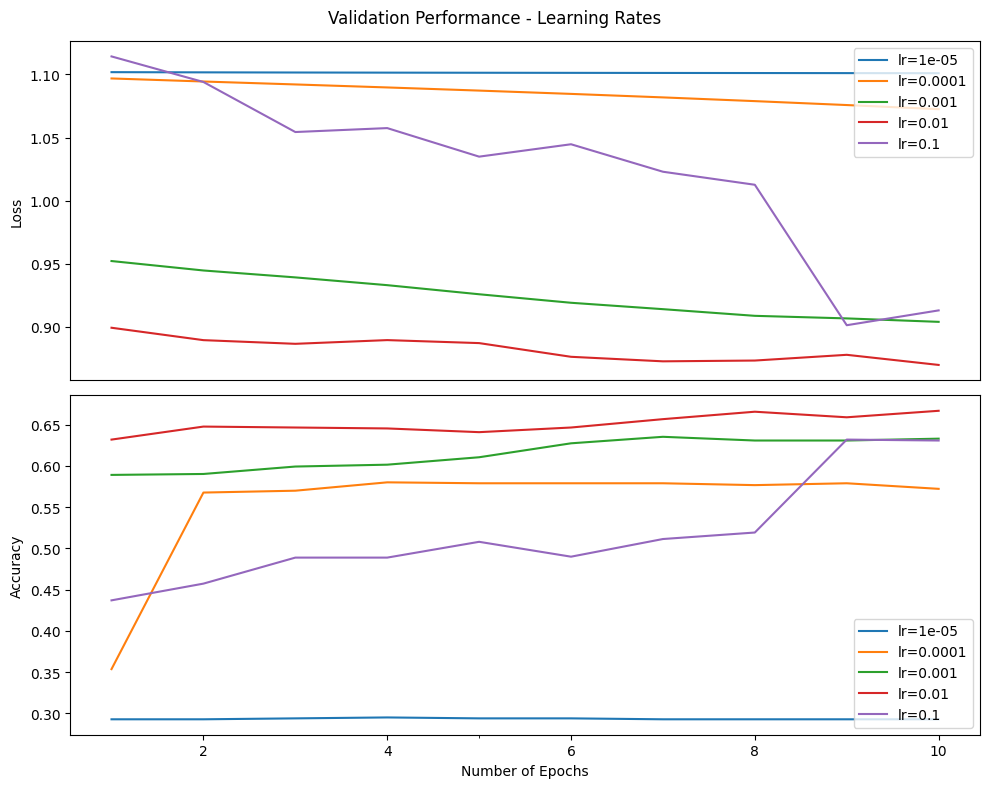

In [24]:
# TODO: 如果有时间，加入scheduler
lr_options = [0.00001, 0.0001, 0.001, 0.01, 0.1]
best_lr = None
best_val_loss = float("inf")
num_epochs = 10


model1 = Model1(
    input_dim=X_train_t.shape[2],
    hidden_dim=128,
    output_dim=3,
    num_layers=2,
    dropout=0.3,
).to(device)

criterion = nn.CrossEntropyLoss()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    10, 8), sharex=True, tight_layout=True)
fig.set_constrained_layout_pads(hspace=0.0, h_pad=0.0)

for lr in lr_options:
    print("-" * 110)
    print(f"Learning rate = {lr}")

    optimizer = optim.Adagrad(model1.parameters(), lr=lr)
    val_losses, val_accuracies = train_and_evaluate(
        model1, criterion, optimizer, num_epochs, verbose=False
    )
    ax1.plot(range(1, num_epochs + 1), val_losses, label="lr=" + str(lr))
    ax2.plot(range(1, num_epochs + 1), val_accuracies, label="lr=" + str(lr))

    val_loss, val_accuracy, val_f1 = evaluate(model1, val_loader1)
    # print('-' * 89)
    print(f"End of training | Val Accuracy: {val_accuracy:.2f} | Val Macro-F1: {
        val_f1:.2f} | Val Loss: {val_loss:.2f}")
    # print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lr = lr

print("=" * 80)

print(f"Best learning rate: {best_lr}")


ax1.set_ylabel("Loss")
ax1.tick_params(axis='x', which='both',
                bottom=False)  # turn off major & minor ticks on the bottom
ax1.legend(loc="upper right")
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.xaxis.set_minor_locator(MultipleLocator(5))
fig.suptitle("Validation Performance - Learning Rates")
save_fig('model1_learning_rate')
plt.show()

--------------------------------------------------------------------------------------------------------------
Learning rate = 1e-05
End of training | Val Accuracy: 0.44 | Val Macro-F1: 0.20 | Val Loss: 1.09
--------------------------------------------------------------------------------------------------------------
Learning rate = 0.0001
End of training | Val Accuracy: 0.59 | Val Macro-F1: 0.45 | Val Loss: 0.95
--------------------------------------------------------------------------------------------------------------
Learning rate = 0.001
End of training | Val Accuracy: 0.65 | Val Macro-F1: 0.63 | Val Loss: 0.88
--------------------------------------------------------------------------------------------------------------
Learning rate = 0.01
End of training | Val Accuracy: 0.69 | Val Macro-F1: 0.68 | Val Loss: 0.86
--------------------------------------------------------------------------------------------------------------
Learning rate = 0.1
End of training | Val Accuracy: 0.58 

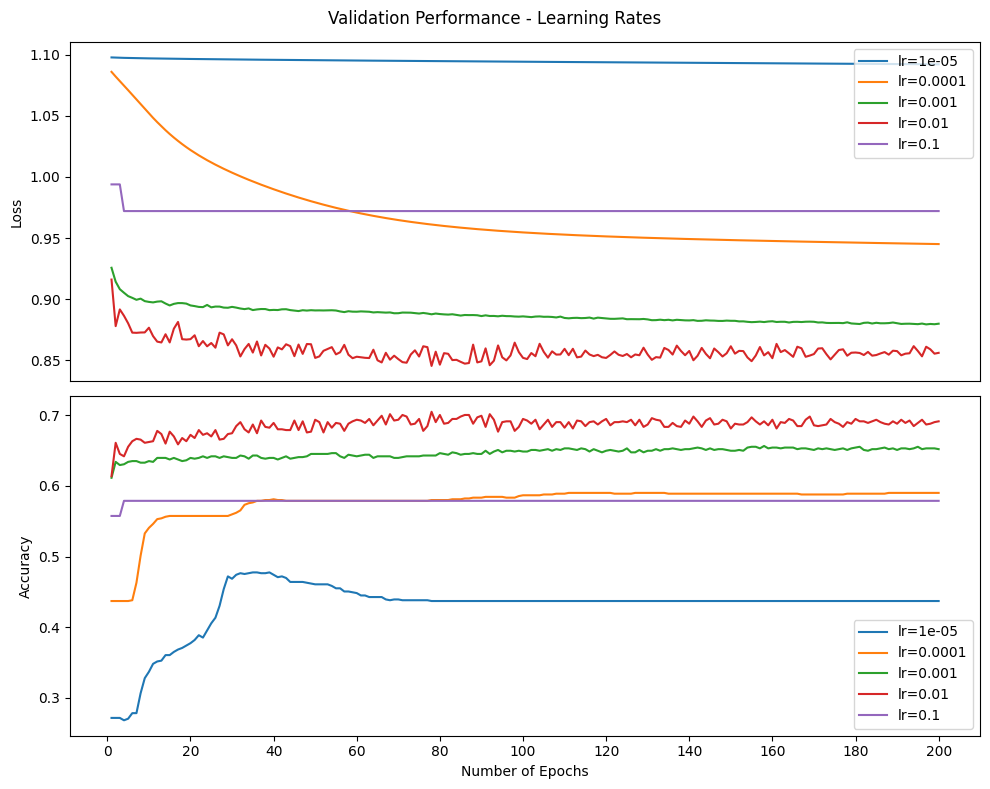

In [25]:

# TODO: 如果有时间，加入scheduler
lr_options = [0.00001, 0.0001, 0.001, 0.01, 0.1]
best_lr = None
best_val_loss = float("inf")
num_epochs = 200


model1 = Model1(
    input_dim=X_train_t.shape[2],
    hidden_dim=128,
    output_dim=3,
    num_layers=2,
    dropout=0.3,
).to(device)

criterion = nn.CrossEntropyLoss()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    10, 8), sharex=True, tight_layout=True)
fig.set_constrained_layout_pads(hspace=0.0, h_pad=0.0)


for lr in lr_options:
    print("-" * 110)
    print(f"Learning rate = {lr}")

    optimizer = optim.Adagrad(model1.parameters(), lr=lr)
    val_losses, val_accuracies = train_and_evaluate(
        model1, criterion, optimizer, num_epochs, verbose=False
    )
    ax1.plot(range(1, num_epochs + 1), val_losses, label="lr=" + str(lr))
    ax2.plot(range(1, num_epochs + 1), val_accuracies, label="lr=" + str(lr))

    val_loss, val_accuracy, val_f1 = evaluate(model1, val_loader1)
    # print('-' * 89)
    print(f"End of training | Val Accuracy: {val_accuracy:.2f} | Val Macro-F1: {
        val_f1:.2f} | Val Loss: {val_loss:.2f}")
    # print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lr = lr

print("=" * 80)

print(f"Best learning rate: {best_lr}")


ax1.set_ylabel("Loss")
ax1.tick_params(axis='x', which='both',
                bottom=False)
ax1.legend(loc="upper right")
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.xaxis.set_major_locator(MultipleLocator(20))
fig.suptitle("Validation Performance - Learning Rates")
save_fig('model1_learning_rate_200_epochs')
plt.show()

### Tuning optimizer

--------------------------------------------------------------------------------------------------------------
Optimizer = Adadelta
End of training | Val Accuracy: 0.44 | Val Macro-F1: 0.20 | Val Loss: 1.09
--------------------------------------------------------------------------------------------------------------
Optimizer = Adagrad
End of training | Val Accuracy: 0.67 | Val Macro-F1: 0.65 | Val Loss: 0.87
--------------------------------------------------------------------------------------------------------------
Optimizer = Adam
End of training | Val Accuracy: 0.60 | Val Macro-F1: 0.58 | Val Loss: 0.95
--------------------------------------------------------------------------------------------------------------
Optimizer = AdamW
End of training | Val Accuracy: 0.63 | Val Macro-F1: 0.59 | Val Loss: 0.92
--------------------------------------------------------------------------------------------------------------
Optimizer = Adamax
End of training | Val Accuracy: 0.64 | Val Macro-F

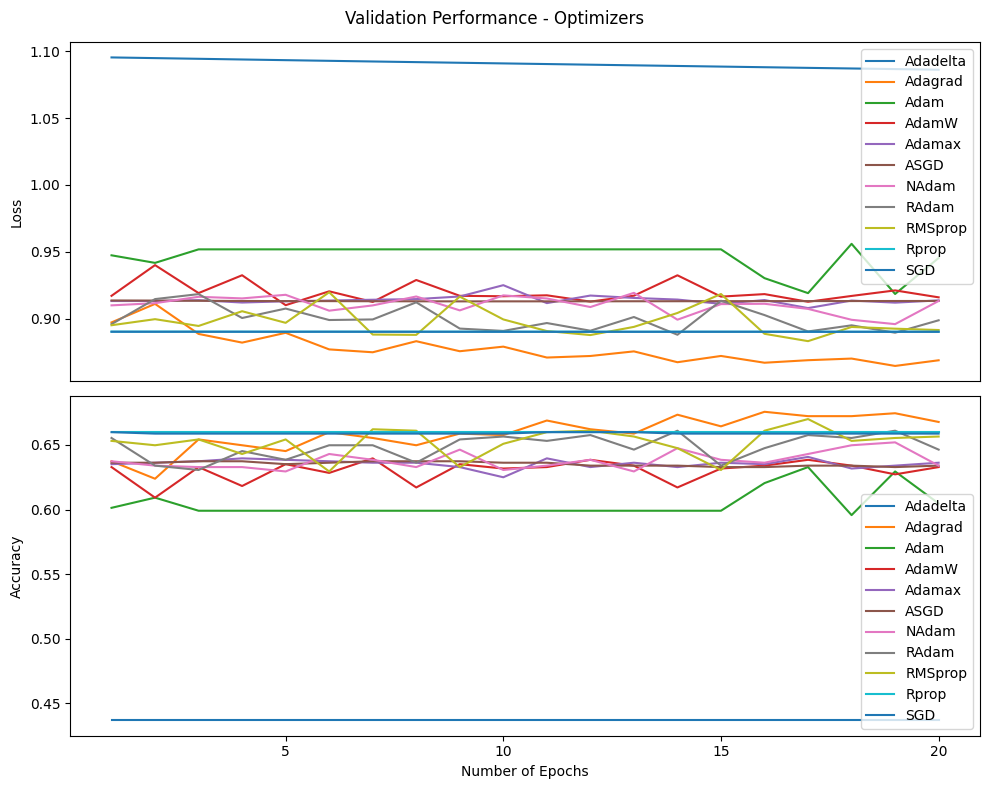

In [29]:
model1 = Model1(
    input_dim=X_train_t.shape[2],
    hidden_dim=128,
    output_dim=3,
    num_layers=2,
    dropout=0.3,
).to(device)

optimizer_options = {'Adadelta': optim.Adadelta(model1.parameters(), lr=best_lr), 'Adagrad': optim.Adagrad(model1.parameters(), lr=best_lr), 'Adam': optim.Adam(model1.parameters(), lr=best_lr), 'AdamW': optim.AdamW(model1.parameters(), lr=best_lr), 'Adamax': optim.Adamax(model1.parameters(), lr=best_lr), 'ASGD': optim.ASGD(model1.parameters(
), lr=best_lr), 'NAdam': optim.NAdam(model1.parameters(), lr=best_lr), 'RAdam': optim.RAdam(model1.parameters(), lr=best_lr), 'RMSprop': optim.RMSprop(model1.parameters(), lr=best_lr), 'Rprop': optim.Rprop(model1.parameters(), lr=best_lr), 'SGD': optim.SGD(model1.parameters(), lr=best_lr)}

best_optimizer = None
best_val_loss = float("inf")
num_epochs = 20


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    10, 8), sharex=True, tight_layout=True)
fig.set_constrained_layout_pads(hspace=0.0, h_pad=0.0)

for (optimizer_name, optim) in optimizer_options.items():
    print("-" * 110)
    print(f"Optimizer = {optimizer_name}")

    optimizer = optim
    val_losses, val_accuracies = train_and_evaluate(
        model1, criterion, optimizer, num_epochs, verbose=False
    )
    ax1.plot(range(1, num_epochs + 1), val_losses,
             label=optimizer_name)
    ax2.plot(range(1, num_epochs + 1), val_accuracies,
             label=optimizer_name)

    val_loss, val_accuracy, val_f1 = evaluate(model1, val_loader1)
    # print('-' * 89)
    print(f"End of training | Val Accuracy: {val_accuracy:.2f} | Val Macro-F1: {
        val_f1:.2f} | Val Loss: {val_loss:.2f}")
    # print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_optimizer = optimizer_name

print("=" * 89)

print(f"Best optimizer: {best_optimizer}")

ax1.set_ylabel("Loss")
ax1.tick_params(axis='x', which='both',
                bottom=False)  # turn off major & minor ticks on the bottom
ax1.legend(loc="upper right")
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.xaxis.set_major_locator(MultipleLocator(5))
# ax.xaxis.set_minor_formatter(FormatStrFormatter('%d'))
fig.suptitle("Validation Performance - Optimizers")
save_fig('model1_optimizer')
plt.show()

### Tuning batch size

--------------------------------------------------------------------------------------------------------------
Batch size = 16
End of training | Val Accuracy: 0.67 | Val Macro-F1: 0.64 | Val Loss: 0.87
--------------------------------------------------------------------------------------------------------------
Batch size = 32
End of training | Val Accuracy: 0.68 | Val Macro-F1: 0.66 | Val Loss: 0.86
--------------------------------------------------------------------------------------------------------------
Batch size = 64
End of training | Val Accuracy: 0.69 | Val Macro-F1: 0.67 | Val Loss: 0.85
--------------------------------------------------------------------------------------------------------------
Batch size = 128
End of training | Val Accuracy: 0.69 | Val Macro-F1: 0.68 | Val Loss: 0.85
--------------------------------------------------------------------------------------------------------------
Batch size = 256
End of training | Val Accuracy: 0.69 | Val Macro-F1: 0.67 | Val

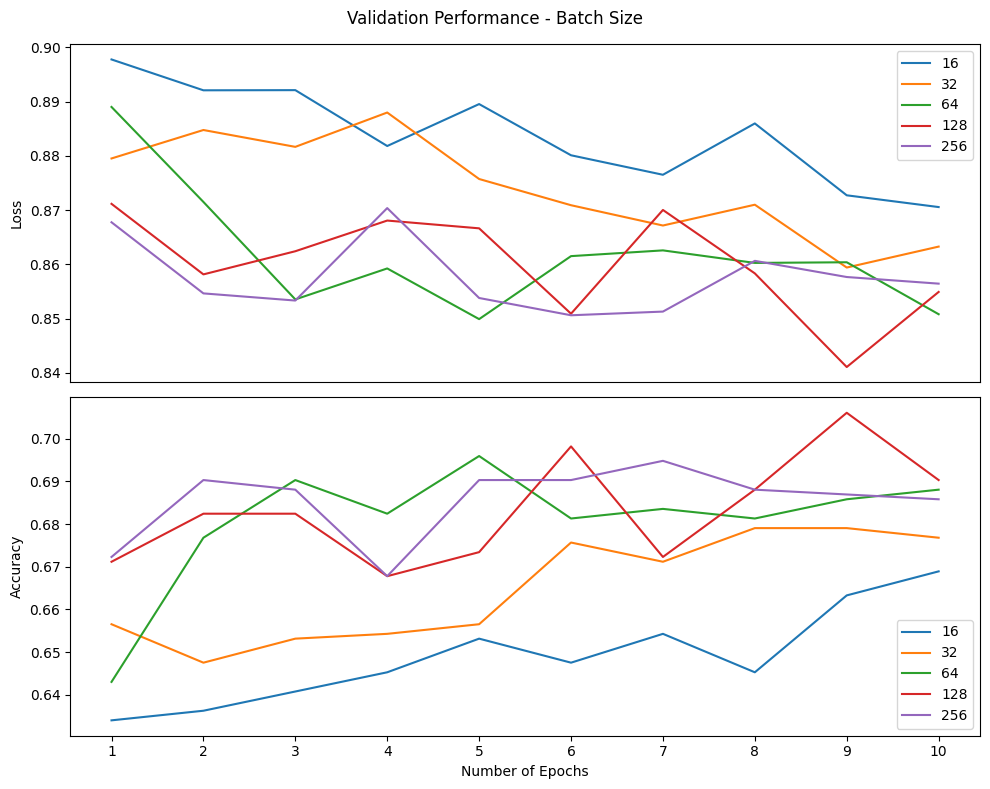

In [127]:
batch_size_options = [16, 32, 64, 128, 256]

model1 = Model1(
    input_dim=X_train_t.shape[2],
    hidden_dim=128,
    output_dim=3,
    num_layers=2,
    dropout=0.3,
).to(device)

best_batch_size = None
best_val_loss = float("inf")
num_epochs = 10


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    10, 8), sharex=True, tight_layout=True)
fig.set_constrained_layout_pads(hspace=0.0, h_pad=0.0)

for batch_size in batch_size_options:
    print("-" * 110)
    print(f"Batch size = {batch_size}")

    train_loader1 = DataLoader(TensorDataset(
        X_train_t, y_train_t), batch_size=batch_size, shuffle=False)
    val_loader1 = DataLoader(TensorDataset(
        X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    test_loader1 = DataLoader(TensorDataset(
        X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

    optimizer = optim.Adagrad(model1.parameters(), lr=0.01)
    val_losses, val_accuracies = train_and_evaluate(
        model1, criterion, optimizer, num_epochs, verbose=False
    )
    ax1.plot(range(1, num_epochs + 1), val_losses,
             label=batch_size)
    ax2.plot(range(1, num_epochs + 1), val_accuracies,
             label=batch_size)

    val_loss, val_accuracy, val_f1 = evaluate(model1, val_loader1)
    # print('-' * 89)
    print(f"End of training | Val Accuracy: {val_accuracy:.2f} | Val Macro-F1: {
        val_f1:.2f} | Val Loss: {val_loss:.2f}")
    # print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_batch_size = batch_size

print("=" * 89)

print(f"Best batch size: {best_batch_size}")

ax1.set_ylabel("Loss")
ax1.tick_params(axis='x', which='both',
                bottom=False)  # turn off major & minor ticks on the bottom
ax1.legend(loc="upper right")
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.xaxis.set_major_locator(MultipleLocator(1))
# ax2.xaxis.set_minor_locator(MultipleLocator(1))
fig.suptitle("Validation Performance - Batch Size")
save_fig('model1_batch_size')
plt.show()

### Tuning hidden neuron size and number of layers

-----------------------------------------------------------------------------------------
Hidden dimension =   64 | Number of layers =  1
End of training | Val Accuracy: 0.65 | Val Macro-F1: 0.63 | Val Loss: 0.88
-----------------------------------------------------------------------------------------
Hidden dimension =   64 | Number of layers =  2
End of training | Val Accuracy: 0.67 | Val Macro-F1: 0.65 | Val Loss: 0.88
-----------------------------------------------------------------------------------------
Hidden dimension =   64 | Number of layers =  3
End of training | Val Accuracy: 0.65 | Val Macro-F1: 0.61 | Val Loss: 0.89
-----------------------------------------------------------------------------------------
Hidden dimension =   64 | Number of layers =  4
End of training | Val Accuracy: 0.65 | Val Macro-F1: 0.63 | Val Loss: 0.88
-----------------------------------------------------------------------------------------
----------------------------------------------------------

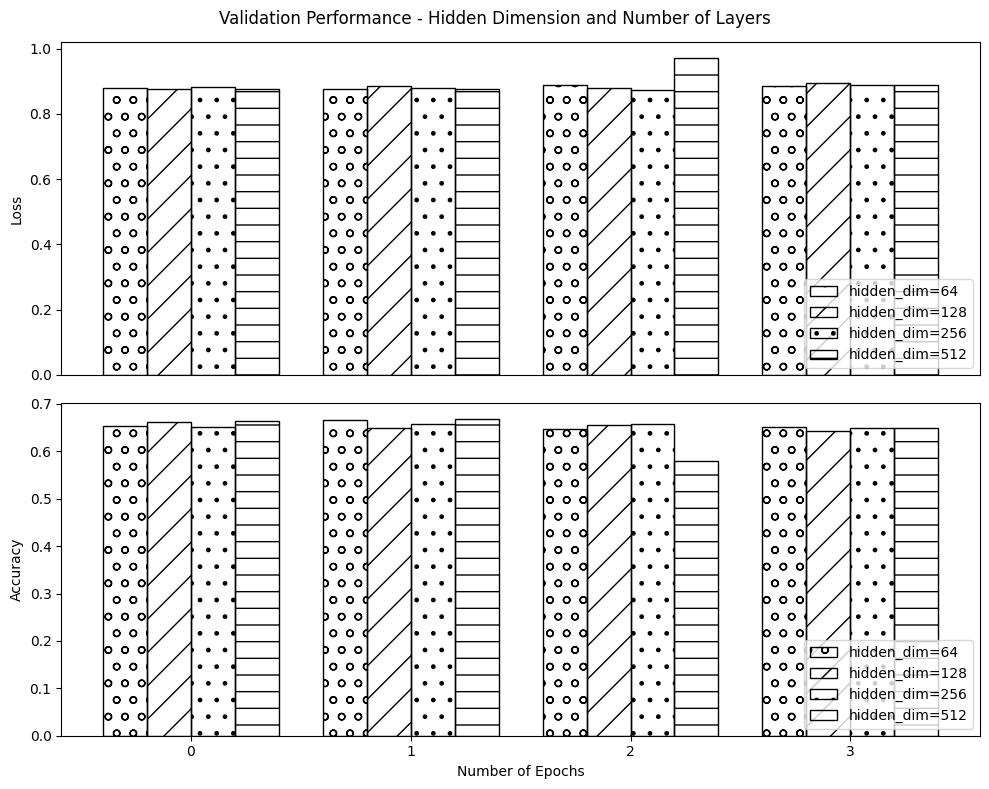

In [32]:
import torch.optim as optim

hidden_dim_options = [64, 128, 256, 512]
n_layers_options = [1, 2, 3, 4]

best_hidden_dim = None
best_n_layers = None
best_val_loss = float("inf")
num_epochs = 10


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    10, 8), sharex=True, tight_layout=True)
fig.set_constrained_layout_pads(hspace=0.0, h_pad=0.0)
X_axis = np.arange(4)
locations = X_axis-0.3
hatch_list = ['o', '/', '.', '-']
it = iter(hatch_list)

for hidden_dim in hidden_dim_options:
    print("=" * 60)
    print('-' * 89)
    losses = []
    accuracies = []
    hatch = next(it)

    for n_layers in n_layers_options:
        print(f"Hidden dimension = {
              hidden_dim:4d} | Number of layers = {n_layers:2d}")

        model1 = Model1(
            input_dim=X_train_t.shape[2],
            hidden_dim=hidden_dim,
            output_dim=3,
            num_layers=n_layers,
            dropout=(0 if n_layers == 1 else 0.3),
        ).to(device)

        optimizer = optim.Adagrad(model1.parameters(), lr=0.01)

        train_and_evaluate(model1, criterion, optimizer,
                           num_epochs, verbose=False)

        val_loss, val_accuracy, val_f1 = evaluate(model1, val_loader1)
        losses.extend([val_loss])
        accuracies.extend([val_accuracy])
        # print('-' * 89)
        print(f"End of training | Val Accuracy: {val_accuracy:.2f} | Val Macro-F1: {
            val_f1:.2f} | Val Loss: {val_loss:.2f}")
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hidden_dim = hidden_dim
            best_n_layers = n_layers

    ax1.bar(locations, losses, 0.2, fill=False, hatch=hatch,
            label='hidden_dim='+str(hidden_dim))
    ax2.bar(locations, accuracies, 0.2, fill=False,
            hatch=hatch, label='hidden_dim='+str(hidden_dim))
    locations += 0.2


print("=" * 60)

print(f"Best hidden dimension: {
      best_hidden_dim} | Best number of layers: {best_n_layers}")

ax1.set_ylabel("Loss")
ax1.tick_params(axis='x', which='both',
                bottom=False)  # turn off major & minor ticks on the bottom
ax1.legend(loc="lower right")
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.xaxis.set_major_locator(MultipleLocator(1))
# ax2.xaxis.set_minor_locator(MultipleLocator(1))
fig.suptitle("Validation Performance - Hidden Dimension and Number of Layers")
save_fig('model1_hidden_size_n_layers')
plt.show()

### Tuning dropout

--------------------------------------------------------------------------------------------------------------
Dropout = 0.0
End of training | Val Accuracy: 0.69 | Val Macro-F1: 0.68 | Val Loss: 0.85
--------------------------------------------------------------------------------------------------------------
Dropout = 0.1
End of training | Val Accuracy: 0.69 | Val Macro-F1: 0.67 | Val Loss: 0.86
--------------------------------------------------------------------------------------------------------------
Dropout = 0.2
End of training | Val Accuracy: 0.69 | Val Macro-F1: 0.68 | Val Loss: 0.85
--------------------------------------------------------------------------------------------------------------
Dropout = 0.3
End of training | Val Accuracy: 0.69 | Val Macro-F1: 0.68 | Val Loss: 0.86
--------------------------------------------------------------------------------------------------------------
Dropout = 0.4
End of training | Val Accuracy: 0.68 | Val Macro-F1: 0.67 | Val Loss: 0.85


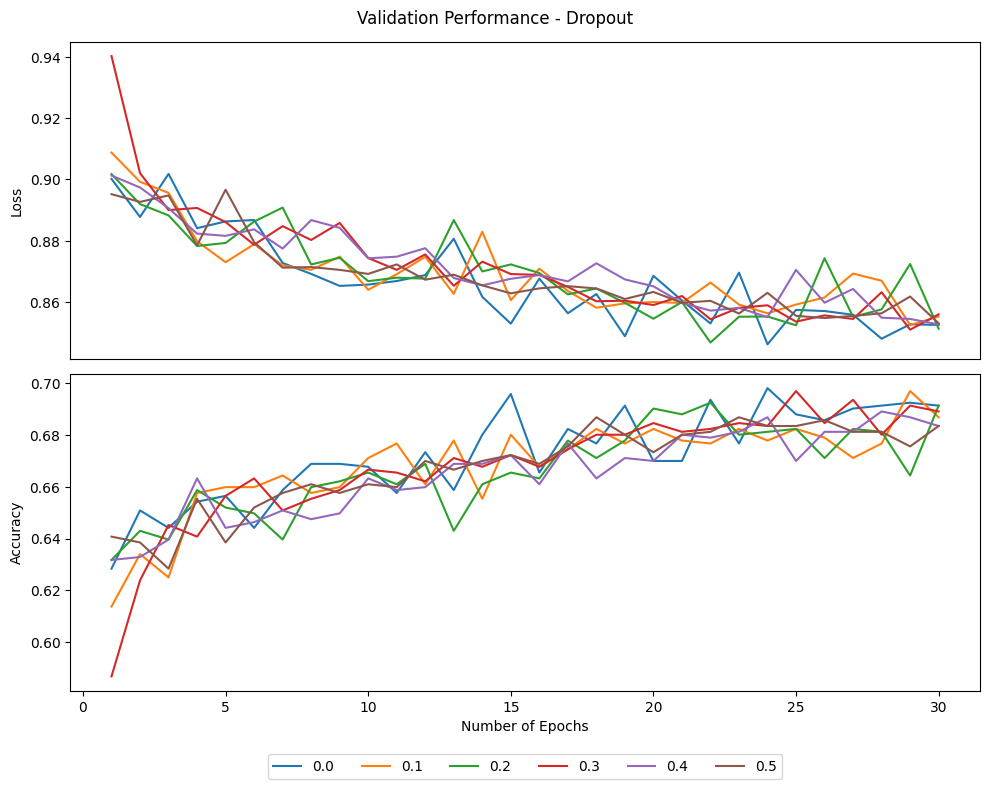

In [26]:
dropout_options = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

best_dropout = None
best_val_loss = float("inf")
num_epochs = 30


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    10, 8), sharex=True, tight_layout=True)
fig.set_constrained_layout_pads(hspace=0.0, h_pad=0.0)

for dropout in dropout_options:
    print("-" * 110)
    print(f"Dropout = {dropout}")

    model1 = Model1(
        input_dim=X_train_t.shape[2],
        hidden_dim=256,
        output_dim=3,
        num_layers=2,
        dropout=dropout,
    ).to(device)

    optimizer = optim.Adagrad(model1.parameters(), lr=0.01)
    val_losses, val_accuracies = train_and_evaluate(
        model1, criterion, optimizer, num_epochs, verbose=False
    )
    ax1.plot(range(1, num_epochs + 1), val_losses,
             label=dropout)
    ax2.plot(range(1, num_epochs + 1), val_accuracies,
             label=dropout)

    val_loss, val_accuracy, val_f1 = evaluate(model1, val_loader1)
    # print('-' * 89)
    print(f"End of training | Val Accuracy: {val_accuracy:.2f} | Val Macro-F1: {
        val_f1:.2f} | Val Loss: {val_loss:.2f}")
    # print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_dropout = dropout

print("=" * 89)

print(f"Best dropout rate: {best_dropout}")

ax1.set_ylabel("Loss")
ax1.tick_params(axis='x', which='both',
                bottom=False)  # turn off major & minor ticks on the bottom
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")
ax2.xaxis.set_major_locator(MultipleLocator(5))
ax2.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.3))
# ax2.xaxis.set_minor_locator(MultipleLocator(1))
fig.suptitle("Validation Performance - Dropout")
save_fig('model1_dropout')
plt.show()

### Final model

In [166]:
import torch.optim as optim

model1 = Model1(
    input_dim=X_train_t.shape[2],
    hidden_dim=256,
    output_dim=3,
    num_layers=2,
    dropout=0.4,
).to(device)

num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model1.parameters(), lr=0.01)

train_and_evaluate(model1, criterion, optimizer, num_epochs)

test_loss, test_accuracy, test_macro_f1 = evaluate(model1, test_loader1)

print('-'*100)
print(f"End of training | Test Accuracy: {test_accuracy:.2f} | Test Macro-F1: {
      test_macro_f1:.2f} | Test Loss: {test_loss:.2f}")

Epoch [1/100] | Train Loss: 0.93 | Train Accuracy: 0.61 | Val Loss: 0.90 | Val Accuracy: 0.62
Epoch [2/100] | Train Loss: 0.90 | Train Accuracy: 0.64 | Val Loss: 0.89 | Val Accuracy: 0.64
Epoch [3/100] | Train Loss: 0.89 | Train Accuracy: 0.65 | Val Loss: 0.90 | Val Accuracy: 0.63
Epoch [4/100] | Train Loss: 0.88 | Train Accuracy: 0.66 | Val Loss: 0.88 | Val Accuracy: 0.65
Epoch [5/100] | Train Loss: 0.88 | Train Accuracy: 0.67 | Val Loss: 0.88 | Val Accuracy: 0.65
Epoch [6/100] | Train Loss: 0.87 | Train Accuracy: 0.67 | Val Loss: 0.89 | Val Accuracy: 0.65
Epoch [7/100] | Train Loss: 0.87 | Train Accuracy: 0.68 | Val Loss: 0.88 | Val Accuracy: 0.65
Epoch [8/100] | Train Loss: 0.87 | Train Accuracy: 0.68 | Val Loss: 0.87 | Val Accuracy: 0.66
Epoch [9/100] | Train Loss: 0.86 | Train Accuracy: 0.68 | Val Loss: 0.89 | Val Accuracy: 0.64
Epoch [10/100] | Train Loss: 0.86 | Train Accuracy: 0.68 | Val Loss: 0.88 | Val Accuracy: 0.65
Epoch [11/100] | Train Loss: 0.86 | Train Accuracy: 0.69 | 

## Model 2

In [33]:
# Evaluation function: returns loss and accuracy
def evaluate_model2(model, dataloader):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sentences, aspects, labels in dataloader:
            sentences = sentences.to(device)
            aspects = aspects.to(device)
            labels = labels.to(device)

            outputs = model(sentences, aspects)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    macro_f1 = f1_score(all_labels, all_predictions, average="macro")

    return avg_loss, accuracy, macro_f1


# Training and validation functions
def train_and_evaluate_model2(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, verbose=True
):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []

        for sentence_embeddings, aspect_embeddings, labels in train_loader:
            # Move data to GPU or CPU
            sentence_embeddings = sentence_embeddings.to(device)
            aspect_embeddings = aspect_embeddings.to(device)
            labels = labels.to(device)

            # Clear gradient
            optimizer.zero_grad()

            # forward propagation
            outputs = model(sentence_embeddings, aspect_embeddings)

            # Calculate losses
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record predictions and labels
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Training set accuracy
        train_accuracy = accuracy_score(all_labels, all_predictions)
        avg_train_loss = total_loss / len(train_loader)

        # Validation set evaluation
        val_loss, val_accuracy, val_f1 = evaluate_model2(model, val_loader)

        # Output loss and accuracy for training and validation
        if verbose:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], "
                f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {
                    train_accuracy:.2f}, "
                f"Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}"
            )

### Genetic algorithm for fine-tuning

In [45]:
import random
import numpy as np


embedding_dim = 300
output_dim = 3
num_layers = 2
dropout = 0.5
learning_rate = 0.001
num_epochs = 10


class GeneticAlgorithm:
    # Initialize Genetic Algorithm with population size, number of generations, and top individual tracking.
    def __init__(self, population_size, generations, num_top_individuals=5, model=2):
        self.population_size = population_size
        self.generations = generations
        self.num_top_individuals = num_top_individuals
        self.top_individuals = []
        self.model = model

    # Function to create a random individual hyperparameter set.
    def create_individual(self):
        return {
            'num_layers': random.choice([2, 3, 4]),
            'hidden_dim': random.choice([64, 128, 256, 512]),
            'dropout': random.choice([0, 0.1, 0.2, 0.3, 0.4]),
            'learning_rate': random.choice([0.001, 0.01, 0.1])
        }

    # Train the model according to hyperparameters defined in each individual and return the validation loss
    def fitness(self, individual):
        # print("-" * 130)
        # print(f"Training with hyperparameters: {individual}")

        criterion = nn.CrossEntropyLoss()
        model = None
        val_loss, val_accuracy, val_f1 = None, None, None

        if self.model == 2:
            model = Model2(embedding_dim, individual['hidden_dim'], output_dim,
                           individual['num_layers'], individual['dropout']).to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            train_and_evaluate_model2(
                model, train_loader2, val_loader2, criterion, optimizer, num_epochs, verbose=False)
            val_loss, val_accuracy, val_f1 = evaluate_model2(
                model, val_loader2)
        elif self.model == 3:
            model = Model3(embedding_dim, embedding_dim,
                           individual['hidden_dim'], output_dim, individual['num_layers'], individual['dropout']).to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            train_and_evaluate_model3(
                model, train_loader2, val_loader2, criterion, optimizer, num_epochs, verbose=False)
            val_loss, val_accuracy, val_f1 = evaluate_model3(
                model, val_loader2)

        # print(f"End of training | Val Accuracy: {val_accuracy:.2f} | Val Macro-F1: {
        #     val_f1:.2f} | Val Loss: {val_loss:.2f}")
        return val_loss

    # Evaluate the entire population's fitness and update the list of top individuals.

    def evaluate_population(self, population):
        fitnesses = []
        for individual in population:
            fitness_score = self.fitness(individual)
            fitnesses.append(fitness_score)
            self.update_top_individuals(individual, fitness_score)
        return fitnesses

    # Update the list of top-performing individuals.
    def update_top_individuals(self, individual, fitness_score):
        self.top_individuals.append((individual.copy(), fitness_score))
        self.top_individuals = sorted(self.top_individuals, key=lambda x: x[1])[
            :self.num_top_individuals]
        # Remove duplicates to ensure diversity among top individuals
        seen = set()
        unique_individuals = []
        for ind, score in self.top_individuals:
            ind_tuple = tuple(ind.items())
            if ind_tuple not in seen:
                seen.add(ind_tuple)
                unique_individuals.append((ind, score))
        self.top_individuals = unique_individuals[:self.num_top_individuals]

    # Select individuals based on fitness to form a new generation (tournament selection).
    def select(self, population, fitnesses):
        selected = []
        for _ in range(len(population)):
            a, b = random.sample(range(len(population)), 2)
            selected.append(population[a] if fitnesses[a]
                            < fitnesses[b] else population[b])
        return selected

    # Crossover function to combine features of two parents to create a child.
    def crossover(self, ind1, ind2):
        child = ind1.copy()
        for key in ind1:
            if random.random() > 0.5:  # Randomly inherit properties from either parent
                child[key] = ind2[key]
        return child

    # Mutate an individual's hyperparameters to introduce variability.
    def mutate(self, individual):
        if random.random() > 0.8:  # Mutation probability
            individual['hidden_dim'] = random.choice([50, 100, 150, 200])
        if random.random() > 0.8:
            individual['dropout'] = random.uniform(0.2, 0.5)

    # Run the genetic algorithm across all generations.
    def run(self):
        population = [self.create_individual()
                      for _ in range(self.population_size)]
        for g in range(self.generations):
            print('='*40)
            print(f'Training generation {g+1}:')
            fitnesses = self.evaluate_population(population)
            population = self.select(population, fitnesses)
            new_population = []
            while len(new_population) < self.population_size:
                ind1, ind2 = random.sample(population, 2)
                child = self.crossover(ind1, ind2)
                self.mutate(child)
                new_population.append(child)
            population = new_population
            print('-'*40)
            print(f"Generation {
                  g+1}: Best Fitness = {self.top_individuals[0][1]}")


    # Retrieve the top individuals from the final generation.
    def get_top_individuals(self):
        return self.top_individuals

### 不要重跑下面的格子，训练时间很长

In [75]:
ga = GeneticAlgorithm(
    population_size=10, generations=20, num_top_individuals=5, model=2
)
ga.run()

print("=" * 80)
print("Top 5 Hyperparameter Combinations:")
for ind, fitness in ga.get_top_individuals():
    print(f"Hyperparameters: {ind}, Fitness (Validation Loss): {fitness:.2f}")

----------------------------------------------------------------------------------------------------------------------------------
Training with hyperparameters: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0, 'learning_rate': 0.01}
End of training | Val Accuracy: 0.66 | Val Macro-F1: 0.64 | Val Loss: 0.89
----------------------------------------------------------------------------------------------------------------------------------
Training with hyperparameters: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'learning_rate': 0.001}
End of training | Val Accuracy: 0.63 | Val Macro-F1: 0.60 | Val Loss: 0.90
----------------------------------------------------------------------------------------------------------------------------------
Training with hyperparameters: {'num_layers': 3, 'hidden_dim': 512, 'dropout': 0, 'learning_rate': 0.001}
End of training | Val Accuracy: 0.60 | Val Macro-F1: 0.50 | Val Loss: 0.95
----------------------------------------------------------------

### Final model

In [40]:
embedding_dim = 300
hidden_dim = 128
output_dim = 3
num_layers = 3
dropout = 0.1
learning_rate = 0.01
num_epochs = 30

# Instantiate the model
model2 = Model2(embedding_dim, hidden_dim, output_dim,
                num_layers, dropout).to(device)

# Loss functions and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

train_and_evaluate_model2(model2, train_loader2,
                          val_loader2, criterion, optimizer, num_epochs)

# After training, evaluate on the test set
test_loss, test_accuracy, test_macro_f1 = evaluate_model2(model2, test_loader2)

print('-'*100)
print(f"End of training | Test Accuracy: {test_accuracy:.4f} | Test Macro-F1: {
      test_macro_f1:.4f} | Test Loss: {test_loss:.4f}")

Epoch [1/30], Train Loss: 1.01, Train Accuracy: 0.53, Val Loss: 0.97, Val Accuracy: 0.58
Epoch [2/30], Train Loss: 0.98, Train Accuracy: 0.57, Val Loss: 0.96, Val Accuracy: 0.59
Epoch [3/30], Train Loss: 0.97, Train Accuracy: 0.58, Val Loss: 0.96, Val Accuracy: 0.59
Epoch [4/30], Train Loss: 0.96, Train Accuracy: 0.59, Val Loss: 0.95, Val Accuracy: 0.60
Epoch [5/30], Train Loss: 0.96, Train Accuracy: 0.59, Val Loss: 0.95, Val Accuracy: 0.60
Epoch [6/30], Train Loss: 0.96, Train Accuracy: 0.59, Val Loss: 0.95, Val Accuracy: 0.60
Epoch [7/30], Train Loss: 0.96, Train Accuracy: 0.59, Val Loss: 0.95, Val Accuracy: 0.60
Epoch [8/30], Train Loss: 0.96, Train Accuracy: 0.59, Val Loss: 0.95, Val Accuracy: 0.60
Epoch [9/30], Train Loss: 0.96, Train Accuracy: 0.59, Val Loss: 0.95, Val Accuracy: 0.60
Epoch [10/30], Train Loss: 0.96, Train Accuracy: 0.59, Val Loss: 0.95, Val Accuracy: 0.60
Epoch [11/30], Train Loss: 0.96, Train Accuracy: 0.59, Val Loss: 0.95, Val Accuracy: 0.60
Epoch [12/30], Trai

## Model 3

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Evaluation function


def evaluate_model3(model, dataloader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for sentences, aspects, labels in dataloader:
            sentences, aspects, labels = (
                sentences.to(device),
                aspects.to(device),
                labels.to(device),
            )

            outputs, _ = model(sentences, aspects)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy, macro_f1


# Training and validation functions
def train_and_evaluate_model3(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, verbose=True
):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []

        for sentence_embeddings, aspect_embeddings, labels in train_loader:
            # Move data to GPU or CPU
            sentence_embeddings = sentence_embeddings.to(device)
            aspect_embeddings = aspect_embeddings.to(device)
            labels = labels.to(device)

            # Clear gradient
            optimizer.zero_grad()

            # forward propagation
            outputs, _ = model(sentence_embeddings, aspect_embeddings)

            # Calculate losses
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record predictions and labels
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Training set accuracy
        train_accuracy = accuracy_score(all_labels, all_predictions)
        avg_train_loss = total_loss / len(train_loader)

        # Validation set evaluation
        val_loss, val_accuracy, val_f1 = evaluate_model3(model, val_loader)

        # Output loss and accuracy for training and validation
        if verbose:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], "
                f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {
                    train_accuracy:.2f}, "
                f"Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}"
            )

### Fine-tune hyperparameters using genetic algorithm

In [46]:
ga = GeneticAlgorithm(
    population_size=10, generations=20, num_top_individuals=5, model=3
)
ga.run()

print("=" * 80)
print("Top 5 Hyperparameter Combinations:")
for ind, fitness in ga.get_top_individuals():
    print(f"Hyperparameters: {ind}, Fitness (Validation Loss): {fitness:.2f}")

Training generation 1:
----------------------------------------
Generation 1: Best Fitness = 0.6780235628996577
Training generation 2:
----------------------------------------
Generation 2: Best Fitness = 0.6750567353197506
Training generation 3:
----------------------------------------
Generation 3: Best Fitness = 0.6695638799241611
Training generation 4:
----------------------------------------
Generation 4: Best Fitness = 0.6485157800572259
Training generation 5:
----------------------------------------
Generation 5: Best Fitness = 0.6485157800572259
Training generation 6:
----------------------------------------
Generation 6: Best Fitness = 0.6485157800572259
Training generation 7:
----------------------------------------
Generation 7: Best Fitness = 0.6485157800572259
Training generation 8:
----------------------------------------
Generation 8: Best Fitness = 0.6485157800572259
Training generation 9:
----------------------------------------
Generation 9: Best Fitness = 0.648515780

### Final model

In [49]:
input_dim = 300
aspect_dim = 300
hidden_dim = 128
output_dim = 3
num_layers = 2
dropout_p = 0.26
num_epochs = 20


model3 = Model3(input_dim, aspect_dim, hidden_dim,
                output_dim, num_layers, dropout_p).to(device)


# Loss functions and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01)

train_and_evaluate_model3(model3, train_loader2,
                          val_loader2, criterion, optimizer, num_epochs)

# Evaluate on the test set
test_loss, test_accuracy, test_macro_f1 = evaluate_model3(model3, test_loader2)

print('-'*100)
print(f"End of training | Test Accuracy: {test_accuracy:.2f} | Test Macro-F1: {
      test_macro_f1:.2f} | Test Loss: {test_loss:.2f}")

Epoch [1/20], Train Loss: 0.94, Train Accuracy: 0.58, Val Loss: 0.94, Val Accuracy: 0.61
Epoch [2/20], Train Loss: 0.89, Train Accuracy: 0.61, Val Loss: 0.86, Val Accuracy: 0.61
Epoch [3/20], Train Loss: 0.84, Train Accuracy: 0.63, Val Loss: 0.78, Val Accuracy: 0.64
Epoch [4/20], Train Loss: 0.80, Train Accuracy: 0.66, Val Loss: 0.77, Val Accuracy: 0.66
Epoch [5/20], Train Loss: 0.75, Train Accuracy: 0.68, Val Loss: 0.71, Val Accuracy: 0.70
Epoch [6/20], Train Loss: 0.72, Train Accuracy: 0.70, Val Loss: 0.75, Val Accuracy: 0.69
Epoch [7/20], Train Loss: 0.70, Train Accuracy: 0.71, Val Loss: 0.73, Val Accuracy: 0.70
Epoch [8/20], Train Loss: 0.68, Train Accuracy: 0.72, Val Loss: 0.68, Val Accuracy: 0.72
Epoch [9/20], Train Loss: 0.65, Train Accuracy: 0.73, Val Loss: 0.67, Val Accuracy: 0.72
Epoch [10/20], Train Loss: 0.64, Train Accuracy: 0.74, Val Loss: 0.69, Val Accuracy: 0.70
Epoch [11/20], Train Loss: 0.62, Train Accuracy: 0.74, Val Loss: 0.67, Val Accuracy: 0.73
Epoch [12/20], Trai

### Visualise attention weights

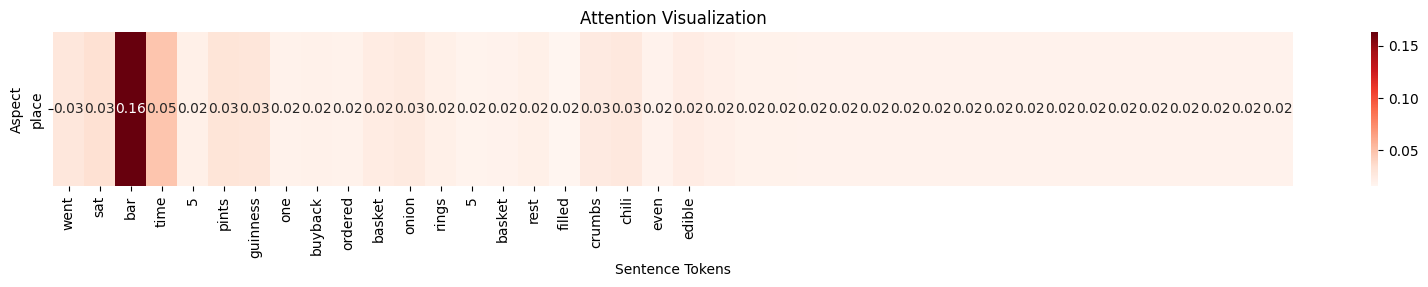

In [52]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)


# Function to visualize attention weights
def visualize_attention(sentence, aspect, attention_weights):
    """
    Visualize attention weights as heat maps.
    :param sentence: Input sentences (list)
    :param aspect: aspect words
    :param attention_weights: attention weight (tensor)
    """
    plt.figure(figsize=(20, 2))
    sns.heatmap(
        attention_weights,
        annot=True,
        fmt=".2f",
        xticklabels=sentence,
        yticklabels=[aspect],
        cmap="Reds",
    )
    plt.xlabel("Sentence Tokens")
    plt.ylabel("Aspect")
    plt.title("Attention Visualization")
    plt.show()


target_index = 0


model3.eval()
with torch.no_grad():
    sentences, aspects = None, None
    current_index = 0
    for batch_sentences, batch_aspects, _ in test_loader2:
        batch_size = batch_sentences.size(0)
        if current_index <= target_index < current_index + batch_size:
            relative_index = target_index - current_index
            sentences = batch_sentences[relative_index].unsqueeze(0).to(device)
            aspects = batch_aspects[relative_index].unsqueeze(0).to(device)
            break
        current_index += batch_size

    # Get the attention weight from the model
    _, attention_weights = model3(sentences, aspects)

    # Get `tokenized_sentence` and `aspect` from `test_df`
    sentence_example = test_df["tokenized_sentence"][target_index]
    aspect_example = test_df["aspect"][target_index]

    visualize_attention(
        sentence_example, aspect_example, attention_weights[0].cpu().numpy()
    )

## Word representation comparison

### glove

In [ ]:
# Instantiate the model and define training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(
    emb_dim, 128, len(vocab), len(label_encoder.classes_), emb_table
).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model and evaluate its performance on the test set after each epoch
number_epochs = 100
for epoch in range(number_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for sentences, labels in train_loader:
        sentences, labels = sentences.to(device), labels.to(device)
        outputs = model(sentences)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = total_correct / total_samples
    print(
        f"Epoch [{epoch+1}/{number_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}"
    )

    # Evaluate the model on the test set
    model.eval()
    total_test_correct = 0
    total_test_samples = 0
    with torch.no_grad():
        for sentences, labels in test_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            outputs = model(sentences)
            _, predicted = torch.max(outputs.data, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test_samples += labels.size(0)

    test_accuracy = total_test_correct / total_test_samples
    print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch [1/100], Loss: 1.0780, Train Accuracy: 0.4289
Test Accuracy: 0.4362
Epoch [2/100], Loss: 1.0773, Train Accuracy: 0.4344
Test Accuracy: 0.4362
Epoch [3/100], Loss: 1.0765, Train Accuracy: 0.4343
Test Accuracy: 0.4362
Epoch [4/100], Loss: 1.0764, Train Accuracy: 0.4343
Test Accuracy: 0.4362
Epoch [5/100], Loss: 1.0768, Train Accuracy: 0.4344
Test Accuracy: 0.4362
Epoch [6/100], Loss: 1.0762, Train Accuracy: 0.4343
Test Accuracy: 0.4362
Epoch [7/100], Loss: 1.0745, Train Accuracy: 0.4339
Test Accuracy: 0.4340
Epoch [8/100], Loss: 1.0754, Train Accuracy: 0.4336
Test Accuracy: 0.4362
Epoch [9/100], Loss: 1.0764, Train Accuracy: 0.4341
Test Accuracy: 0.4362
Epoch [10/100], Loss: 1.0706, Train Accuracy: 0.4344
Test Accuracy: 0.4340
Epoch [11/100], Loss: 1.0422, Train Accuracy: 0.4258
Test Accuracy: 0.4562
Epoch [12/100], Loss: 1.0208, Train Accuracy: 0.4437
Test Accuracy: 0.4462
Epoch [13/100], Loss: 1.0035, Train Accuracy: 0.4528
Test Accuracy: 0.4573
Epoch [14/100], Loss: 0.9919, Trai

Lei的bilstm根据gpt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# First we need to convert the label in string format into an integer
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(
    y_train
)  # Fit label encoder and return encoded labels
y_val_encoded = label_encoder.transform(y_val)  # Transform labels to encoded version
y_test_encoded = label_encoder.transform(y_test)  # Transform labels to encoded version

# Convert numpy arrays to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(
    1
)  # Add sequence length dimension
y_train_t = torch.tensor(y_train_encoded, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val_encoded, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test_encoded, dtype=torch.long)

# Create Tensor datasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define the BiLSTM Model
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Initial states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Select last time step's output
        out = self.fc(out[:, -1, :])
        return out


# Model initialization
embedding_dim = X_train.shape[1]  # Number of features
hidden_dim = 128
num_layers = 2
output_dim = len(set(y_train_encoded))  # Number of unique labels

model = BiLSTM(embedding_dim, hidden_dim, num_layers, output_dim).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Function to evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    true_labels, predicted_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    return true_labels, predicted_labels


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    train_true, train_preds = evaluate_model(model, train_loader)
    val_true, val_preds = evaluate_model(model, val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Accuracy: {accuracy_score(train_true, train_preds):.4f}")
    print(f"Validation Accuracy: {accuracy_score(val_true, val_preds):.4f}")

# Evaluate on test data
test_true, test_preds = evaluate_model(model, test_loader)
print("Test Performance:")
print(classification_report(test_true, test_preds))

Epoch 1/10
Training Accuracy: 0.6340
Validation Accuracy: 0.6419
Epoch 2/10
Training Accuracy: 0.6543
Validation Accuracy: 0.6318
Epoch 3/10
Training Accuracy: 0.6577
Validation Accuracy: 0.6385
Epoch 4/10
Training Accuracy: 0.6650
Validation Accuracy: 0.6622
Epoch 5/10
Training Accuracy: 0.6800
Validation Accuracy: 0.6644
Epoch 6/10
Training Accuracy: 0.6935
Validation Accuracy: 0.6712
Epoch 7/10
Training Accuracy: 0.6952
Validation Accuracy: 0.6836
Epoch 8/10
Training Accuracy: 0.6999
Validation Accuracy: 0.6881
Epoch 9/10
Training Accuracy: 0.7154
Validation Accuracy: 0.6881
Epoch 10/10
Training Accuracy: 0.7181
Validation Accuracy: 0.6892
Test Performance:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       263
           1       0.70      0.84      0.76       393
           2       0.61      0.49      0.54       245

    accuracy                           0.68       901
   macro avg       0.67      0.65      0.65       901
weigh